In [2]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from sp_extension import *

In [3]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all_csvs"
brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

In [4]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/p5-240826-091418/Notes.txt
read from t=0s to t=790.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/nn2-250117-085631/Notes.txt
read from t=0s to t=814.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/p2-240523-081105/Notes.txt
read from t=0s to t=788.65s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/nn4-250118-094351/Notes.txt
read from t=0s to t=795.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/n6-240826-094701/Notes.txt
read from t=0s to t=800.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Social_Pref/all/nn1-25011

In [5]:
bout_definitions = [
    {'prefix': 'Subject', 'introduced': 'Subject Introduced', 'removed': 'Subject Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for p5-240826-091418...
Processing behaviors for nn2-250117-085631...
Processing behaviors for p2-240523-081105...
Processing behaviors for nn4-250118-094351...
Processing behaviors for n6-240826-094701...
Processing behaviors for nn1-250117-081652...
Processing behaviors for pp7-250118-075659...
Processing behaviors for pp3-250118-064713...
Processing behaviors for p8-240827-075823...
Processing behaviors for nn8-250118-105443...
Processing behaviors for n3-240523-073132...
Processing behaviors for p1-240522-080200...
Processing behaviors for n5-240826-083822...
Processing behaviors for n4-240523-084829...
Processing behaviors for p6-240827-065303...
Processing behaviors for pp5-250117-121543...
Processing behaviors for pp4-250118-072201...
Processing behaviors for nn7-250118-101917...
Processing behaviors for pp8-250118-083250...
Processing behaviors for nn6-250117-101903...
Processing behaviors for p7-240826-102402...
Processing behaviors for pp6-250117-124823..

## Long-Term Bar Graph - Total Investigation Time

In [6]:
import os
import pandas as pd

def fix_behavior_data_for_experiment(experiment, csv_base_path):
    """
    Loads and converts raw CSVs into behavior DataFrames for each trial in the experiment.
    Replaces experiment.trials[trial_name].behaviors with the corrected DataFrame.
    """
    fixed_trials = 0
    skipped_trials = 0

    for trial_name in experiment.trials:
        csv_file = os.path.join(csv_base_path, trial_name + ".csv")

        if not os.path.exists(csv_file):
            print(f"CSV not found for trial '{trial_name}' — skipped.")
            skipped_trials += 1
            continue

        try:
            raw_df = pd.read_csv(csv_file)

            # Only process rows that have Start, Stop, Duration
            if {"Start (s)", "Stop (s)", "Duration (s)", "Behavior"}.issubset(raw_df.columns):
                behavior_df = pd.DataFrame({
                    "Behavior": raw_df["Behavior"],
                    "Event_Start": raw_df["Start (s)"],
                    "Event_End": raw_df["Stop (s)"],
                    "Duration (s)": raw_df["Duration (s)"],
                    "Bout": raw_df.get("Subject", "Subject-1")  # fallback if no 'Subject'
                })

                # Clean up NaNs, e.g., missing durations
                behavior_df.dropna(subset=["Event_Start", "Event_End", "Duration (s)"], inplace=True)

                # Inject into experiment object
                experiment.trials[trial_name].behaviors = behavior_df.reset_index(drop=True)
                fixed_trials += 1
            else:
                print(f"CSV for trial '{trial_name}' missing required columns — skipped.")
                skipped_trials += 1

        except Exception as e:
            print(f"Error processing trial '{trial_name}': {e}")
            skipped_trials += 1

    print(f"\nFinished processing CSVs.")
    print(f"Fixed trials: {fixed_trials}")
    print(f"Skipped trials: {skipped_trials}")

In [7]:
def plot_custom_sniff_cup_assignments(experiment, bar_color='#cccccc', figsize=(6, 8)):
    """
    For each subject, extracts total investigation time for a pre-assigned 'sniff cup X' behavior,
    and plots the mean + individual data points.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3",
        "P1": "sniff cup 4",
        "N2": "sniff cup 1",
        "P3": "sniff cup 2",
        "N3": "sniff cup 2",
        "P2": "sniff cup 1",
        "N4": "sniff cup 4",
        "P4": "sniff cup 3",
        "N5": "sniff cup 3",
        "P5": "sniff cup 4",
        "N6": "sniff cup 1",
        "P7": "sniff cup 2",
        "P6": "sniff cup 1",
        "N7": "sniff cup 2",
        "P8": "sniff cup 3",
        "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1",
        "Nn5": "sniff cup 2",
        "Nn6": "sniff cup 3",
        "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1",
        "Pp5": "sniff cup 2",
        "Pp6": "sniff cup 3",
        "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3",
        "Pp7": "sniff cup 4",
        "Pp8": "sniff cup 1",
        "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3",
        "Nn7": "sniff cup 4",
        "Nn8": "sniff cup 1"
    }

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match the trial name prefix to the assignment key (case-insensitive)
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                print(f"Skipped trial '{trial_name}' — no subject assignment match.")
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned sniff cup behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                print(f"Skipped trial '{trial_name}' — no data for '{target_behavior}'.")
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            subject_data.append({
                "Subject": trial_name,
                "Total Investigation Time": total_time,
                "Assigned Behavior": target_behavior
            })
            valid_trials += 1
        else:
            skipped_empty += 1
            print(f"Skipped trial '{trial_name}' — empty behaviors DataFrame.")

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # Plot
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color, edgecolor='black', linewidth=3, width=0.6)

    for _, row in data_df.iterrows():
        subj = row["Subject"]
        time = row["Total Investigation Time"]

        if subj.lower().startswith('n'):
            color = "#15616F"
        elif subj.lower().startswith('p'):
            color = "#FFAF00"
        else:
            color = "gray"

        ax.plot(0, time, 'o', color=color, markersize=10)

    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time (Custom Cups)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()



Finished processing CSVs.
Fixed trials: 31
Skipped trials: 0

Total trials: 31
Valid trials with matched behavior: 31
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 31


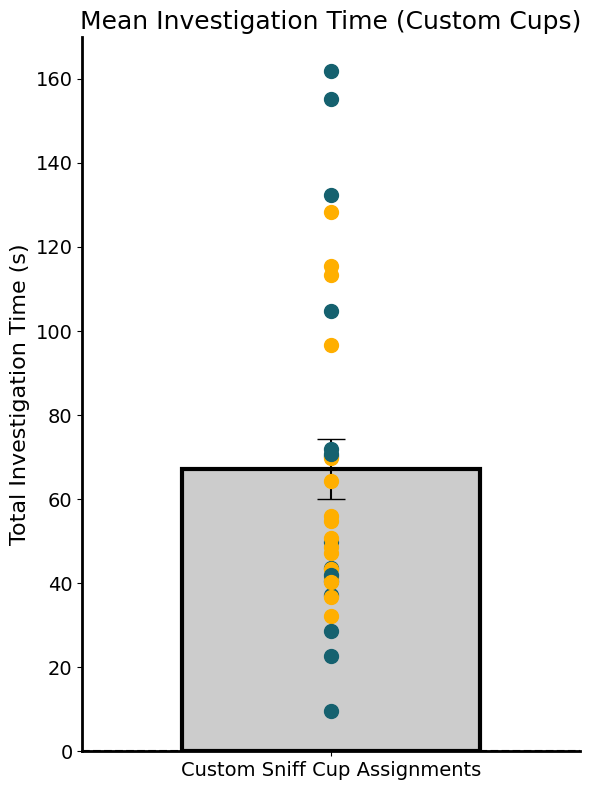

In [8]:
# Run this before plotting
fix_behavior_data_for_experiment(experiment, csv_base_path)

# Now all experiment.trials[...].behaviors are valid — plot will work!
plot_custom_sniff_cup_assignments(experiment)

### With colors

In [9]:
def plot_grouped_sniff_cup_assignments(experiment, 
                                       bar_color='#cccccc', 
                                       color_nn_pp="red", 
                                       color_n_p="blue", 
                                       figsize=(10, 8)):
    """
    Groups subjects by prefix:
      - nn/pp subjects → one color
      - n/p subjects → another color
    Plots their assigned sniff cup investigation times with a legend.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3", "P1": "sniff cup 4", "N2": "sniff cup 1", "P3": "sniff cup 2",
        "N3": "sniff cup 2", "P2": "sniff cup 1", "N4": "sniff cup 4", "P4": "sniff cup 3",
        "N5": "sniff cup 3", "P5": "sniff cup 4", "N6": "sniff cup 1", "P7": "sniff cup 2",
        "P6": "sniff cup 1", "N7": "sniff cup 2", "P8": "sniff cup 3", "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1", "Nn5": "sniff cup 2", "Nn6": "sniff cup 3", "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1", "Pp5": "sniff cup 2", "Pp6": "sniff cup 3", "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3", "Pp7": "sniff cup 4", "Pp8": "sniff cup 1", "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3", "Nn7": "sniff cup 4", "Nn8": "sniff cup 1"
    }

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match trial to subject key
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            # Determine color group
            if matched_key.lower().startswith(("nn", "pp")):
                color = color_nn_pp
                group_label = "nn / pp"
            else:
                color = color_n_p
                group_label = "n / p"

            subject_data.append({
                "Trial": trial_name,
                "Group": group_label,
                "Total Investigation Time": total_time,
                "Color": color
            })
            valid_trials += 1
        else:
            skipped_empty += 1

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # --- Plot ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Plot mean bar
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color,
           edgecolor='black', linewidth=3, width=0.6)

    # Plot individual data points by group color
    for _, row in data_df.iterrows():
        ax.plot(0, row["Total Investigation Time"], 'o', color=row["Color"], markersize=10)

    # Labels & formatting
    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time (Grouped Colors)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    # Legend for color groups
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_n_p,
                   markersize=10, label="Cohort 1 + 2"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_nn_pp,
                   markersize=10, label="Cohort 3")
    ]
    ax.legend(handles=legend_elements, title="Groups", loc='upper left', fontsize=10, title_fontsize=12)

    plt.tight_layout()
    plt.show()



Total trials: 31
Valid trials with matched behavior: 31
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 31


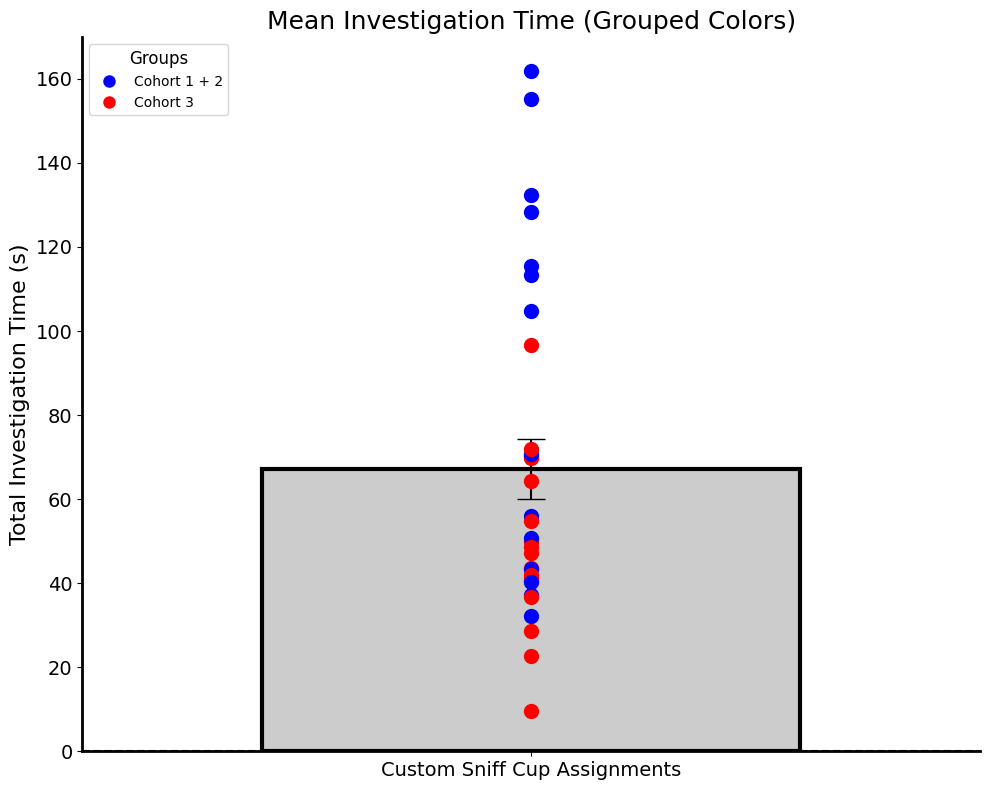

In [10]:
plot_grouped_sniff_cup_assignments(experiment)

In [11]:
def plot_grouped_sniff_cup_assignments(experiment, 
                                       bar_color='#cccccc', 
                                       color_nn_pp="red", 
                                       color_n_p="blue", 
                                       figsize=(10, 8)):
    """
    Groups subjects by prefix:
      - nn/pp subjects → one color
      - n/p subjects → another color
    Plots their assigned sniff cup investigation times with a legend showing count above/below mean.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3", "P1": "sniff cup 4", "N2": "sniff cup 1", "P3": "sniff cup 2",
        "N3": "sniff cup 2", "P2": "sniff cup 1", "N4": "sniff cup 4", "P4": "sniff cup 3",
        "N5": "sniff cup 3", "P5": "sniff cup 4", "N6": "sniff cup 1", "P7": "sniff cup 2",
        "P6": "sniff cup 1", "N7": "sniff cup 2", "P8": "sniff cup 3", "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1", "Nn5": "sniff cup 2", "Nn6": "sniff cup 3", "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1", "Pp5": "sniff cup 2", "Pp6": "sniff cup 3", "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3", "Pp7": "sniff cup 4", "Pp8": "sniff cup 1", "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3", "Nn7": "sniff cup 4", "Nn8": "sniff cup 1"
    }

    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match trial to subject key
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            # Determine color group
            if matched_key.lower().startswith(("nn", "pp")):
                color = color_nn_pp
                group_label = "nn / pp"
            else:
                color = color_n_p
                group_label = "n / p"

            subject_data.append({
                "Trial": trial_name,
                "Group": group_label,
                "Total Investigation Time": total_time,
                "Color": color
            })
            valid_trials += 1
        else:
            skipped_empty += 1

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # --- Compute stats ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    # Count above and on/below the mean
    above_mean = (data_df["Total Investigation Time"] > mean_time).sum()
    below_or_equal_mean = (data_df["Total Investigation Time"] <= mean_time).sum()

    print(f"Mice ABOVE mean: {above_mean}, Mice ON/BELOW mean: {below_or_equal_mean}")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # Plot mean bar
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color,
           edgecolor='black', linewidth=3, width=0.6)

    # Plot individual data points by group color
    for _, row in data_df.iterrows():
        ax.plot(0, row["Total Investigation Time"], 'o', color=row["Color"], markersize=10)

    # Labels & formatting
    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time (Grouped Colors)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    # Legend with count info
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_n_p,
                   markersize=10, label="n / p subjects"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_nn_pp,
                   markersize=10, label="nn / pp subjects"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
                   markersize=0, label=f"Above mean: {above_mean}"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
                   markersize=0, label=f"On/Below mean: {below_or_equal_mean}")
    ]
    ax.legend(handles=legend_elements, title="Groups + Counts", loc='upper left', fontsize=10, title_fontsize=12)

    plt.tight_layout()
    plt.show()



Total trials: 31
Valid trials with matched behavior: 31
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 31
Mice ABOVE mean: 12, Mice ON/BELOW mean: 19


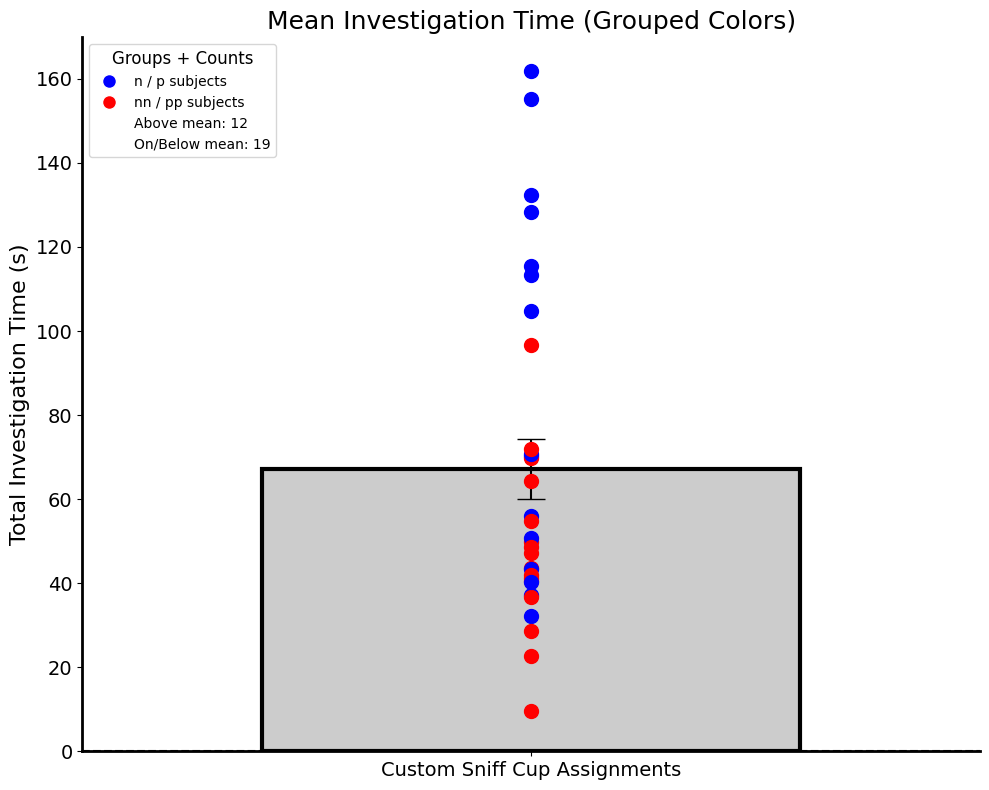

In [12]:
plot_grouped_sniff_cup_assignments(experiment)


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_custom_sniff_cup_assignments_with_legend(experiment, bar_color='#cccccc', figsize=(12, 8)):
    """
    For each subject, extracts total investigation time for a pre-assigned 'sniff cup X' behavior,
    plots individual data in a unique color per subject, and adds a legend mapping subject → color.
    """

    # --- Hardcoded sniff cup assignments ---
    subject_to_behavior = {
        "N1": "sniff cup 3",
        "P1": "sniff cup 4",
        "N2": "sniff cup 1",
        "P3": "sniff cup 2",
        "N3": "sniff cup 2",
        "P2": "sniff cup 1",
        "N4": "sniff cup 4",
        "P4": "sniff cup 3",
        "N5": "sniff cup 3",
        "P5": "sniff cup 4",
        "N6": "sniff cup 1",
        "P7": "sniff cup 2",
        "P6": "sniff cup 1",
        "N7": "sniff cup 2",
        "P8": "sniff cup 3",
        "Nn1": "sniff cup 4",
        "Nn2": "sniff cup 1",
        "Nn5": "sniff cup 2",
        "Nn6": "sniff cup 3",
        "Pp1": "sniff cup 4",
        "Pp2": "sniff cup 1",
        "Pp5": "sniff cup 2",
        "Pp6": "sniff cup 3",
        "Pp3": "sniff cup 2",
        "Pp4": "sniff cup 3",
        "Pp7": "sniff cup 4",
        "Pp8": "sniff cup 1",
        "Nn3": "sniff cup 2",
        "Nn4": "sniff cup 3",
        "Nn7": "sniff cup 4",
        "Nn8": "sniff cup 1"
    }

    # --- Unique color for each subject ---
    subject_colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#393b79", "#637939",
        "#8c6d31", "#843c39", "#7b4173", "#5254a3", "#9c9ede", "#cedb9c",
        "#bd9e39", "#d6616b", "#e7969c", "#a55194", "#de9ed6", "#6b6ecf",
        "#9c9ede", "#637939", "#e7ba52", "#e7969c", "#843c39", "#8c6d31", "#7b4173"
    ]

    subject_to_color = dict(zip(subject_to_behavior.keys(), subject_colors))

    # --- Data collection ---
    subject_data = []
    total_trials = len(experiment.trials)
    valid_trials = 0
    skipped_empty = 0
    skipped_unmatched = 0
    skipped_no_behavior = 0

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            # Match trial to subject key
            matched_key = None
            for key in subject_to_behavior:
                if trial_name.lower().startswith(key.lower()):
                    matched_key = key
                    break

            if not matched_key:
                print(f"Skipped trial '{trial_name}' — no subject assignment match.")
                skipped_unmatched += 1
                continue

            target_behavior = subject_to_behavior[matched_key].lower()

            # Filter for the assigned behavior
            behavior_df = df[df["Behavior"].str.lower() == target_behavior]
            if behavior_df.empty:
                print(f"Skipped trial '{trial_name}' — no data for '{target_behavior}'.")
                skipped_no_behavior += 1
                continue

            total_time = behavior_df["Duration (s)"].sum()

            subject_data.append({
                "Trial": trial_name,
                "Subject Key": matched_key,
                "Total Investigation Time": total_time,
                "Color": subject_to_color[matched_key]
            })
            valid_trials += 1
        else:
            skipped_empty += 1
            print(f"Skipped trial '{trial_name}' — empty behaviors DataFrame.")

    print(f"\nTotal trials: {total_trials}")
    print(f"Valid trials with matched behavior: {valid_trials}")
    print(f"Skipped (empty): {skipped_empty}, Skipped (no match): {skipped_unmatched}, Skipped (no behavior data): {skipped_no_behavior}")

    if not subject_data:
        print("No valid investigation data found for custom assignments.")
        return

    data_df = pd.DataFrame(subject_data)

    num_subjects = len(data_df)
    print(f"Number of mice (data points) plotted: {num_subjects}")

    # --- Plot ---
    mean_time = data_df["Total Investigation Time"].mean()
    sem_time = data_df["Total Investigation Time"].sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Plot mean bar
    ax.bar(0, mean_time, yerr=sem_time, capsize=10, color=bar_color,
           edgecolor='black', linewidth=3, width=0.6)

    # Plot individual data points with unique colors
    for _, row in data_df.iterrows():
        ax.plot(0, row["Total Investigation Time"], 'o', color=row["Color"], markersize=10)

    # Set labels and title
    ax.set_xticks([0])
    ax.set_xticklabels(["Custom Sniff Cup Assignments"], fontsize=14)
    ax.set_ylabel("Total Investigation Time (s)", fontsize=16)
    ax.set_title("Mean Investigation Time per Subject (Custom Cups)", fontsize=18)
    ax.set_xlim(-0.5, 0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

    # Beautify plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14)

    # --- Legend ---
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=subject_to_color[key],
                   markersize=10, label=key)
        for key in subject_to_behavior.keys()
    ]

    ax.legend(handles=legend_elements, title="Subjects", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12, borderaxespad=0.)

    plt.tight_layout()
    plt.show()



Total trials: 31
Valid trials with matched behavior: 31
Skipped (empty): 0, Skipped (no match): 0, Skipped (no behavior data): 0
Number of mice (data points) plotted: 31


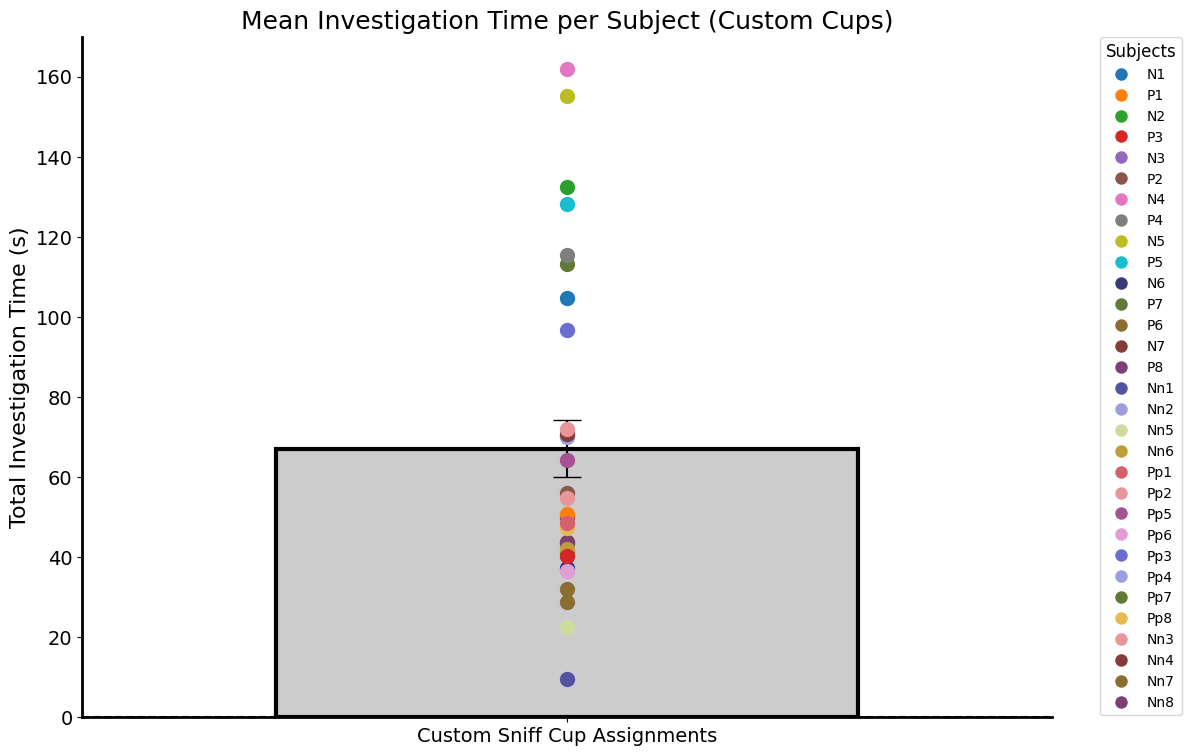

In [14]:
plot_custom_sniff_cup_assignments_with_legend(experiment)

## Bimodal Behavior

In [33]:
def get_trial_dataframes_with_ids(experiment):
    """
    Given an Experiment object, return a list of (subject_id, DataFrame) tuples,
    where each DataFrame corresponds to the .behaviors of each trial.
    The subject_id is extracted from the trial name.
    """
    trial_dataframes = []

    for trial_id, trial in experiment.trials.items():
        # Extract subject ID (e.g., 'n1', 'pp3') from the trial name
        subject_id = trial_id.split('-')[0].lower()  # Convert to lowercase for consistency
        df = trial.behaviors

        # Only include if behaviors exist and are not empty
        if df is not None and not df.empty:
            trial_dataframes.append((subject_id, df.copy()))
        else:
            print(f"Skipping {trial_id}: no behavior data.")

    return trial_dataframes

dfs_with_ids = get_trial_dataframes_with_ids(experiment)

In [37]:
import pandas as pd

def compute_agent_investigation_metrics(dfs_with_ids, agent_map_path):
    """
    Loads agent mapping from CSV file, maps sniff cup behaviors to agent types per subject,
    and computes:
    - Total Investigation Time per Agent
    - Average Bout Duration per Agent

    Parameters:
    - dfs_with_ids: List of (subject_id, DataFrame) pairs.
    - agent_map_path: File path to CSV (or Excel) mapping sniff cup columns to agent types.

    Returns:
    - A DataFrame: rows=subject_ids, columns=total/average per agent type.
    """
    # Load CSV or Excel mapping file
    if agent_map_path.endswith('.xlsx') or agent_map_path.endswith('.xls'):
        agent_map_df = pd.read_excel(agent_map_path)
    else:
        agent_map_df = pd.read_csv(agent_map_path)

    # Normalize subject IDs in mapping
    agent_map_df['Subject'] = agent_map_df['Subject'].str.lower()

    results = []

    for subj_id, df in dfs_with_ids:
        subj_id_lower = subj_id.lower()

        # Get mapping row for this subject
        mapping_row = agent_map_df[agent_map_df['Subject'] == subj_id_lower]
        if mapping_row.empty:
            print(f"Warning: No mapping for {subj_id}. Skipping.")
            continue

        # Map sniff cups to agent types
        cup_to_agent = {}
        for cup_col in ['sniff cup 1', 'sniff cup 2', 'sniff cup 3', 'sniff cup 4']:
            agent_type = mapping_row.iloc[0][cup_col]
            cup_to_agent[cup_col] = agent_type.lower() if pd.notna(agent_type) else None

        # Filter and relabel
        df = df[df['Behavior'].str.startswith('sniff cup', na=False)].copy()
        df['Agent Type'] = df['Behavior'].map(cup_to_agent)
        df = df[df['Agent Type'].notnull()]

        if df.empty:
            print(f"{subj_id} has no valid sniff cup behaviors after filtering.")
            continue

        # Compute metrics
        group = df.groupby('Agent Type')
        row_data = {'Subject': subj_id}
        for agent, agent_df in group:
            total_time = agent_df['Duration (s)'].sum()
            num_bouts = agent_df['Bout'].nunique()
            avg_bout = total_time / num_bouts if num_bouts else 0

            row_data[f'Total_{agent}'] = total_time
            row_data[f'Avg_{agent}'] = avg_bout

        results.append(row_data)

    result_df = pd.DataFrame(results).set_index('Subject').fillna(0)
    return result_df

# Path to your CSV or Excel file
agent_map_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/Social_Pref_Cup_Assignments.csv"

# Prepare dfs_with_ids: list of (subject_id, DataFrame) from get_trial_dataframes_with_ids()
dfs_with_ids = get_trial_dataframes_with_ids(experiment)

# Call the function
result_df = compute_agent_investigation_metrics(dfs_with_ids, agent_map_path)

# View result
result_df



,Total_long_term,Avg_long_term,Total_nothing,Avg_nothing,Total_novel,Avg_novel,Total_short_term,Avg_short_term,Total_novel,Avg_novel
Subject,,,,,,,,,,
p5,128.300,128.300,42.700,42.700,48.500,48.500,51.600,51.600,0.000,0.000
nn2,40.400,40.400,49.900,49.900,0.000,0.000,75.699,75.699,81.199,81.199
p2,55.932,55.932,98.998,98.998,79.063,79.063,54.731,54.731,0.000,0.000
nn4,43.700,43.700,60.900,60.900,84.500,84.500,36.900,36.900,0.000,0.000
n6,37.300,37.300,40.521,40.521,40.900,40.900,86.698,86.698,0.000,0.000
nn1,9.600,9.600,93.000,93.000,55.998,55.998,35.100,35.100,0.000,0.000
pp7,41.300,41.300,61.400,61.400,104.899,104.899,57.500,57.500,0.000,0.000
pp3,96.600,96.600,50.700,50.700,27.300,27.300,15.600,15.600,0.000,0.000
p8,43.400,43.400,88.899,88.899,65.100,65.100,71.400,71.400,0.000,0.000


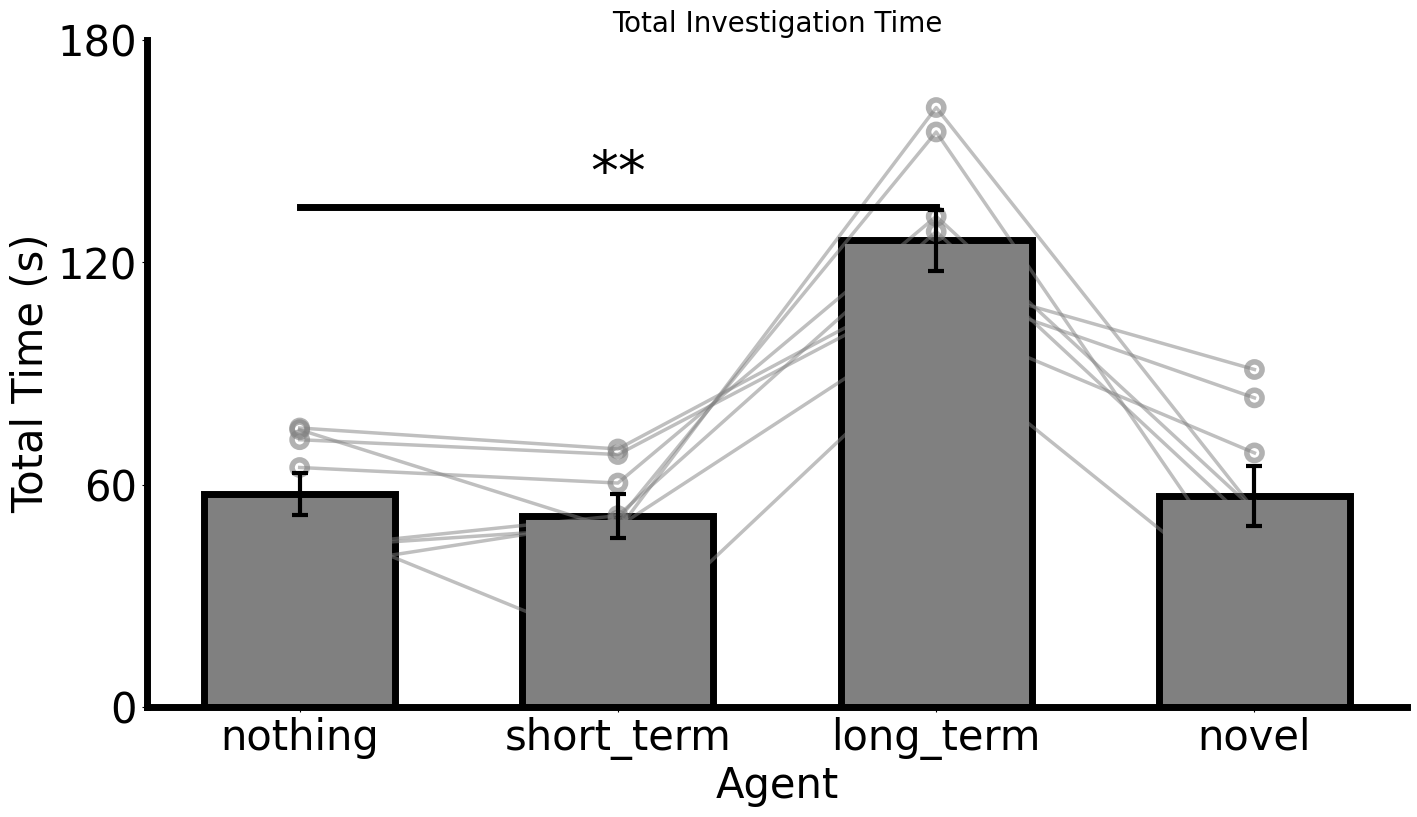

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

def plot_investigation_by_agent(df,  
                                 metric_type='total',  # 'total' or 'average'
                                 subjects_to_plot=None,
                                 title='Investigation Time by Agent', 
                                 ylabel='Investigation Time (s)', 
                                 ylim=None, 
                                 bar_color='#00B7D7',
                                 yticks_increment=None, 
                                 xlabel='Agent',
                                 figsize=(12,7), 
                                 pad_inches=0.1):
    """
    Plots investigation metrics across agent types: nothing, short_term, long_term, novel.
    
    Parameters:
        - df: DataFrame with rows=subjects, columns like Total_novel, Avg_nothing, etc.
        - metric_type: 'total' or 'average' (choose which metric to plot).
        - subjects_to_plot: List of subject IDs to include.
        [Other plot params...]
    """
    agent_order = ['nothing', 'short_term', 'long_term', 'novel']
    column_prefix = 'Total_' if metric_type == 'total' else 'Avg_'
    
    # --- Filter by subjects if provided ---
    if subjects_to_plot:
        df = df[df.index.str.lower().isin([s.lower() for s in subjects_to_plot])]
        if df.empty:
            print("No matching subjects found.")
            return

    # --- Select and reorder columns ---
    cols_to_plot = [f"{column_prefix}{agent}" for agent in agent_order if f"{column_prefix}{agent}" in df.columns]
    if not cols_to_plot:
        print(f"No matching columns for metric '{metric_type}'.")
        return
    df_plot = df[cols_to_plot].copy()
    df_plot.columns = agent_order[:len(cols_to_plot)]  # Clean column names for x-axis

    # --- T-tests ---
    def perform_t_tests(data_df):
        comparisons = {
            "nothing_vs_short": ("nothing", "short_term"),
            "nothing_vs_long": ("nothing", "long_term"),
            "nothing_vs_novel": ("nothing", "novel")
        }
        results = {}
        for key, (a1, a2) in comparisons.items():
            if a1 in data_df.columns and a2 in data_df.columns:
                paired = data_df[[a1, a2]].dropna()
                if len(paired) > 1:
                    t_stat, p_val = ttest_rel(paired[a1], paired[a2])
                    results[key] = {"t_stat": t_stat, "p_value": p_val}
        return results

    t_test_results = perform_t_tests(df_plot)

    # --- Plotting ---
    mean_vals = df_plot.mean()
    sem_vals = df_plot.sem()
    fig, ax = plt.subplots(figsize=figsize)

    # Bars
    ax.bar(df_plot.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))

    # Spaghetti lines
    for subject in df_plot.index:
        ax.plot(df_plot.columns, df_plot.loc[subject],
                linestyle='-', color='gray', alpha=0.5, linewidth=2.5, zorder=1)
        ax.scatter(df_plot.columns, df_plot.loc[subject],
                   facecolors='none', edgecolors='gray', s=120, alpha=0.6, linewidth=4, zorder=2)

    # Labels
    ax.set_ylabel(ylabel, fontsize=30)
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_title(title, fontsize=20)

    # Ticks
    ax.set_xticks(np.arange(len(df_plot.columns)))
    ax.set_xticklabels(df_plot.columns, fontsize=28)
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Y-limits
    all_vals = np.concatenate([df_plot.values.flatten(), mean_vals.values])
    min_val, max_val = np.nanmin(all_vals), np.nanmax(all_vals)
    lower_ylim = 0 if min_val > 0 else min_val * 1.1
    upper_ylim = max_val * 1.1
    ax.set_ylim(ylim if ylim else (lower_ylim, upper_ylim))
    if (ylim and ylim[0] < 0) or (not ylim and lower_ylim < 0):
        ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Y-ticks
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment))

    # Aesthetics
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # Significance lines
    if t_test_results:
        sig_y_offset = ax.get_ylim()[1] * 0.05
        comparison_indices = {"nothing_vs_short": (0, 1), "nothing_vs_long": (0, 2), "nothing_vs_novel": (0, 3)}
        current_y = mean_vals.max() + sig_y_offset
        for key, (x1, x2) in comparison_indices.items():
            if key in t_test_results:
                p_val = t_test_results[key]["p_value"]
                if p_val < 0.05:
                    stars = "**" if p_val < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 2, stars,
                            fontsize=40, ha='center', color='black')
                    current_y += sig_y_offset * 2.5

    plt.tight_layout(pad=pad_inches)
    plt.show()

# Assume 'df_agents' is your DataFrame with Total/Avg columns as shown in your screenshot

# Subjects to include
selected_subjects = ['n4', 'n5', 'n2', 'p5', 'p4', 'p7', 'n1', 'pp3']


# Plot average investigation time by agent
plot_investigation_by_agent(result_df,
                            metric_type='total',
                            subjects_to_plot=selected_subjects,
                            title="Total Investigation Time",
                            ylabel="Total Time (s)",
                            bar_color='grey',
                            yticks_increment=60,
                            figsize=(14, 8))


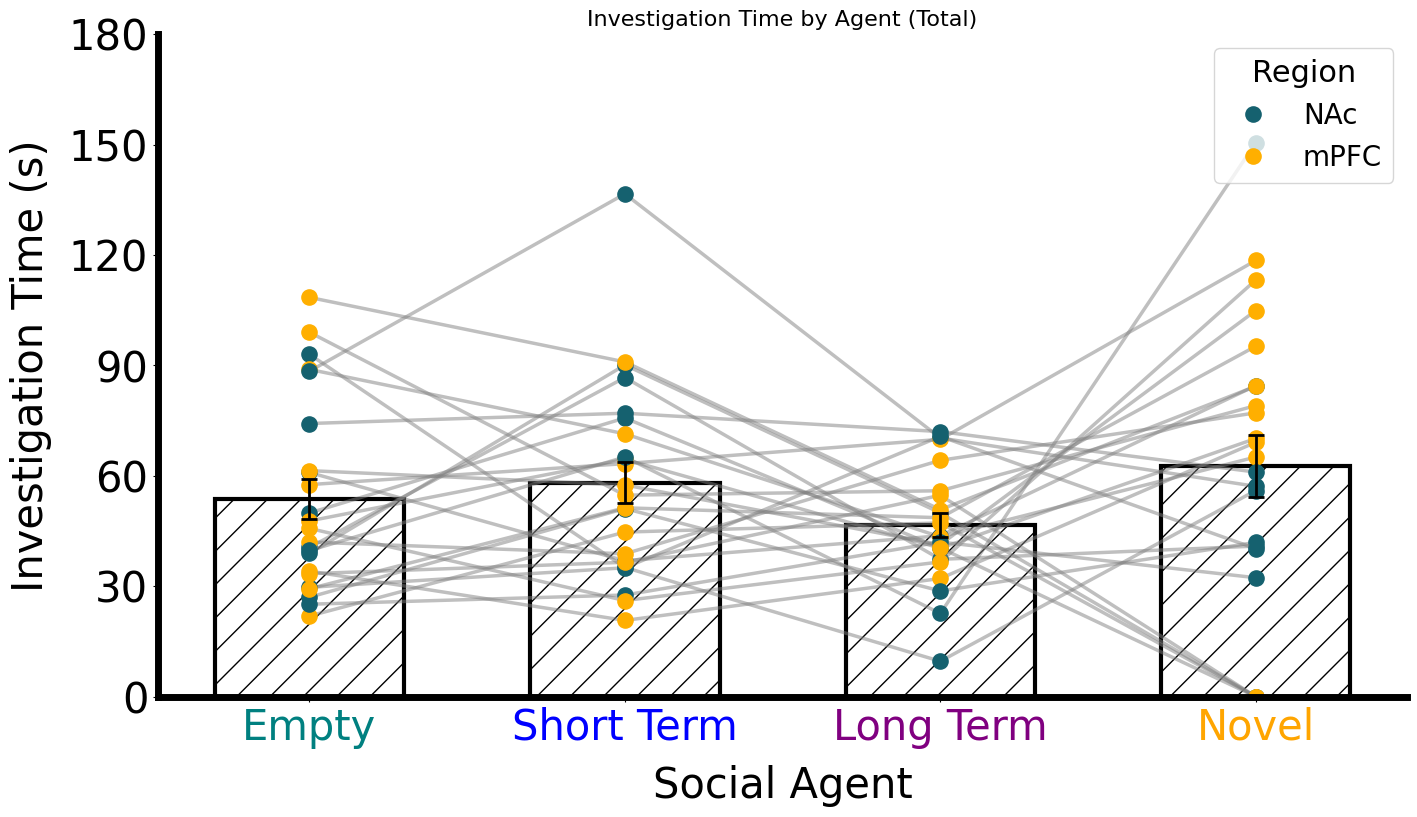

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D


def plot_investigation_by_agent(df,
                                 subjects_to_include=None,
                                 metric="Total",  # "Total" or "Avg"
                                 title='Investigation Time by Agent',
                                 ylabel='Investigation Time (s)',
                                 xlabel='Agent',
                                 custom_xtick_labels=None,
                                 custom_xtick_colors=None,
                                 ylim=None,
                                 bar_fill_color='white',
                                 bar_edge_color='black',
                                 bar_linewidth=3,
                                 bar_hatch='///',
                                 yticks_increment=None,
                                 figsize=(12, 7),
                                 pad_inches=0.1):
    """
    Plots investigation time (Total or Avg) across agents: nothing, short_term, long_term, novel.

    Parameters:
        - df (DataFrame): Includes subject-wise columns for Total/Avg per agent.
        - subjects_to_include (list or None): Filter to only these subjects (if provided).
        - metric (str): 'Total' or 'Avg' to choose which metric to plot.
        - Aesthetic and figure parameters same as in plot_y_across_bouts_gray.
    """

    # --- Ensure Subject column exists ---
    df = df.copy()
    if 'Subject' not in df.columns:
        df.reset_index(inplace=True)
    df['Subject'] = df['Subject'].astype(str)
    df.set_index('Subject', inplace=True)

    # Filter by specific subjects if provided
    if subjects_to_include:
        subjects_to_include = [s.lower() for s in subjects_to_include]
        df = df[df.index.str.lower().isin(subjects_to_include)]

    # Define correct column order
    agents = ['nothing', 'short_term', 'long_term', 'novel']
    columns_to_plot = [f"{metric}_{agent}" for agent in agents]

    # Ensure columns exist
    missing_cols = [col for col in columns_to_plot if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        return

    # Subset and rename columns for plotting
    df_plot = df[columns_to_plot].copy()
    df_plot.columns = agents  # Clean column names for x-axis

    # --- T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "nothing_vs_short_term": ("nothing", "short_term"),
            "nothing_vs_long_term": ("nothing", "long_term"),
            "nothing_vs_novel": ("nothing", "novel")
        }
        results = {}
        for key, (a1, a2) in comparisons.items():
            if a1 in df_vals.columns and a2 in df_vals.columns:
                paired = df_vals[[a1, a2]].dropna()
                if len(paired) > 1:
                    t_stat, p_value = ttest_rel(paired[a1], paired[a2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(df_plot)

    # --- Stats ---
    mean_vals = df_plot.mean()
    sem_vals = df_plot.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(df_plot.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

    # --- Lines + Colored Markers ---
    for subject_id, row in df_plot.iterrows():
        subject_prefix = str(subject_id).lower().strip()
        if subject_prefix.startswith('n'):
            marker_color = '#15616F'  # NAc
        elif subject_prefix.startswith('p'):
            marker_color = '#FFAF00'  # mPFC
        else:
            marker_color = 'gray'  # fallback

        # Gray line
        ax.plot(df_plot.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

        # Colored opaque filled circles, no border, behind error bars
        ax.scatter(df_plot.columns, row.values, color=marker_color,
                   s=120, alpha=1.0, zorder=1)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(df_plot.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df_plot.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # --- Y-limits ---
    all_vals = np.concatenate([df_plot.values.flatten(), mean_vals.values])
    if ylim is None:
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # --- Y-ticks ---
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Aesthetic ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Significance Markers ---
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "nothing_vs_short_term": (0, 1),
            "nothing_vs_long_term": (0, 2),
            "nothing_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing

    # --- Legend for Region Colors with Dots ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
               markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
               markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]

    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
              loc='upper right', frameon=True)

    plt.tight_layout(pad=pad_inches)
    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.show()


# Sample subject list (lowercase)
subjects_to_plot = [
    'n3', 'p1', 'p3', 'p2', 'n6', 'p6', 'n7', 'p8', 'nn1', 'nn2', 'nn5', 'nn6',
    'pp1', 'pp2', 'pp5', 'pp6', 'pp4', 'pp7', 'pp8', 'nn3', 'nn4', 'nn7', 'nn8'
]

# Sample call to plot Total Investigation Time
plot_investigation_by_agent(
    df=result_df,                      # <- Replace with your actual DataFrame variable
    subjects_to_include=subjects_to_plot,
    metric="Total",                         # or "Avg"
    title="Investigation Time by Agent (Total)",
    ylabel="Investigation Time (s)",
    xlabel="Social Agent",
    custom_xtick_labels=["Empty", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0, 180),
    bar_fill_color='white',
    bar_edge_color='black',
    bar_linewidth=3,
    bar_hatch='/',
    yticks_increment=30,
    figsize=(14, 8),
    pad_inches=0.1
)

In [43]:
print(result_df.index.name)
print(result_df.columns)


Subject
Index(['Total_long_term', 'Avg_long_term', 'Total_nothing', 'Avg_nothing',
       'Total_novel', 'Avg_novel', 'Total_short_term', 'Avg_short_term',
       'Total_novel ', 'Avg_novel '],
      dtype='object')


In [ ]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]

    return trial_dataframes

def process_investigation_data(df, 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Processes all 'sniff cup' behaviors: merges events, filters short ones, and aggregates by subject/bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    gap_threshold : float
        Max gap (in seconds) to merge consecutive events.
    min_duration : float
        Minimum duration threshold (below = remove event).
    desired_bouts : list or None
        If provided, keep only specified bouts.
    agg_func : {'sum', 'mean'}
        How to aggregate durations in final output.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """

    # --- 1) Filter only 'sniff cup' behaviors ---
    df_filtered = df[df["Behavior"].str.contains("sniff cup", case=False, na=False)].copy()
    if df_filtered.empty:
        print("No 'sniff cup' behaviors found.")
        return pd.DataFrame()

    # --- 2) Sort events by Subject and Event_Start ---
    df_filtered.sort_values(["Subject", "Event_Start"], inplace=True)
    df_filtered.reset_index(drop=True, inplace=True)

    # --- 3) Assign group IDs to merge consecutive events ---
    df_filtered["new_block"] = (
        (df_filtered["Subject"] != df_filtered["Subject"].shift(1)) |
        (df_filtered["Event_Start"] - df_filtered["Event_End"].shift(1) > gap_threshold)
    )
    df_filtered["group_id"] = df_filtered["new_block"].cumsum()

    # --- 4) Merge events within each group ---
    merged = (
        df_filtered.groupby("group_id", as_index=False)
        .agg({
            "Subject":      "first",
            "Behavior":     "first",
            "Bout":         "first",
            "Event_Start":  "min",
            "Event_End":    "max",
            "Duration (s)": "sum"
        })
    )

    # --- 5) Filter out events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()

    # --- 6) Filter to desired bouts if specified ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]

    # --- 7) Group and pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")

    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )

    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df

def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_color='#00B7D7',
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1):
    """
    Plots the mean values (with SEM) across bouts with individual-subject lines.
    Also performs a paired t-test comparing the average of s1-1 & s1-2 vs. the
    average of s1-5 & s2-2, drawing a significance line if p < 0.05.

    Parameters:
        - df (DataFrame): A DataFrame where rows are subjects, and bouts are columns.
                          Values are the mean values (e.g., mean DA, investigation times)
                          for each subject and bout.
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - custom_xtick_labels (list): Custom x-tick labels. If not provided,
                                      defaults to df column names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels.
        - ylim (tuple): (min, max) for y-axis. If None, automatically set.
        - bar_color (str): The color for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - xlabel (str): The label for the x-axis.
        - figsize (tuple): The figure size.
        - pad_inches (float): Figure padding when saving.
    """
    """
    Plots the mean values during investigations or other events across bouts with error bars for SEM,
    and individual subject lines connecting the bouts. All subjects are plotted in gray.

    Performs t-tests and plots significance markers above bars.
    """

    def perform_t_tests(df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel using pivot_df."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in df.columns and bout2 in df.columns:
                # Drop NaN values and ensure equal-length pairs
                paired_df = df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:  # Ensure enough data points for paired t-test
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Compute t-test results using the nested function
    t_test_results = perform_t_tests(df)

    # Calculate mean and SEM
    mean_values = df.mean()
    sem_values = df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Bar plot with error bars
    bars = ax.bar(
        df.columns, 
        mean_values, 
        yerr=sem_values, 
        capsize=6,
        color=bar_color,
        edgecolor='black', 
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    # Plot all subject lines in gray
    for subject in df.index:
        ax.plot(df.columns, df.loc[subject],
                linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

    # Plot unfilled circle markers (larger size) in gray
    for subject in df.index:
        ax.scatter(df.columns, df.loc[subject], 
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # Labels & Title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # Set x-ticks
    ax.set_xticks(np.arange(len(df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df.columns, fontsize=26)

    # Increase tick label size
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Handle y-limits
    if ylim is None:
        # Automatically set based on data range
        all_values = np.concatenate([df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set y-ticks if increment is provided
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min),
                            np.ceil(y_max) + yticks_increment,
                            yticks_increment)
        ax.set_yticks(y_ticks)

    # Remove right & top spines, thicken left & bottom
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust to separate significance lines
        current_y = mean_values.max() + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout()
    plt.show() 

In [ ]:
desired_bouts = ["sniff cup 1", "sniff cup 2", "sniff cup 3", "sniff cup 4"]

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    gap_threshold=0.3,
    min_duration=1e-10,
    desired_bouts=None,
    agg_func='sum'
)

In [28]:
dfs

[       Behavior  Event_Start  Event_End  Duration (s)     Bout
 0   sniff cup 2        189.4      196.4           7.0  Subject
 1   sniff cup 2        198.6      200.8           2.2  Subject
 2   sniff cup 4        203.5      205.0           1.5  Subject
 3   sniff cup 4        206.4      207.3           0.9  Subject
 4   sniff cup 3        208.6      210.2           1.6  Subject
 5   sniff cup 1        211.9      218.2           6.3  Subject
 6   sniff cup 3        219.9      226.8           6.9  Subject
 7   sniff cup 4        231.4      243.4          12.0  Subject
 8   sniff cup 2        246.4      249.1           2.7  Subject
 9   sniff cup 3        259.2      259.7           0.5  Subject
 10  sniff cup 4        262.2      264.2           2.0  Subject
 11  sniff cup 4        265.9      271.5           5.6  Subject
 12  sniff cup 4        272.3      280.0           7.7  Subject
 13  sniff cup 2        284.4      286.7           2.3  Subject
 14  sniff cup 4        293.2      302.0

In [26]:
pivot

Bout
Subject


In [19]:
def plot_selected_subjects(pivot_df, 
                           subjects_to_plot, 
                           plot_func=plot_y_across_bouts_gray,
                           **plot_kwargs):
    """
    Filters the pivot DataFrame to only include subjects whose IDs start with specified prefixes.

    Parameters:
    - pivot_df: DataFrame from process_investigation_data (index=subjects).
    - subjects_to_plot: List of string prefixes (e.g., ['N4', 'P5']).
    - plot_func: Plotting function to use (default: plot_y_across_bouts_gray).
    - plot_kwargs: Additional kwargs to pass to the plotting function.
    """
    # Normalize prefixes for matching
    subjects_to_plot_lower = [s.lower() for s in subjects_to_plot]
    
    # Ensure subject IDs (index) are treated as strings
    pivot_df.index = pivot_df.index.astype(str)

    # Filter: keep any subject whose ID starts with one of the provided prefixes
    mask = pivot_df.index.to_series().str.lower().apply(
        lambda subj_id: any(subj_id.startswith(prefix) for prefix in subjects_to_plot_lower)
    )
    filtered_df = pivot_df.loc[mask]

    if filtered_df.empty:
        print("No matching subjects found in DataFrame.")
        return

    print(f"Plotting {len(filtered_df)} subject(s): {filtered_df.index.tolist()}")
    
    # Call the provided plot function
    plot_func(filtered_df, **plot_kwargs)

subjects_of_interest = ['n4', 'n5', 'n2', 'p5', 'p4', 'p7', 'n1', 'pp3']

plot_selected_subjects(pivot,
                       subjects_to_plot=subjects_of_interest,
                       title="Investigation Times: Selected Mice",
                       ylabel="Investigation Time (s)",
                       xlabel="Bout",
                       bar_color="#00B7D7",
                       yticks_increment=5,
                       figsize=(14, 8))

No matching subjects found in DataFrame.


In [23]:
print("pivot shape:", pivot.shape)
print("pivot index (subjects):", list(pivot.index))
print("pivot columns (bouts):", list(pivot.columns))



pivot shape: (0, 0)
pivot index (subjects): []
pivot columns (bouts): []


## Behavior

In [ ]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())
    print(trial_ids)

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]
    print(trial_dataframes)

    return trial_dataframes

def process_investigation_data(df, 
                               behavior_name='Investigation', 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Merge consecutive Investigation events within 'gap_threshold' seconds,
    remove events shorter than 'min_duration', then group/pivot by Subject & Bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    behavior_name : str
        Which behavior to combine/filter (default 'Investigation').
    gap_threshold : float
        Max gap (in seconds) to consider consecutive events mergeable.
    min_duration : float
        Minimum duration below which events are removed.
    desired_bouts : list or None
        Which bouts to keep (if None, keep all).
    agg_func : {'sum', 'mean'}
        How to combine the durations in the final group step.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """
    
    #--- 1) Keep only rows matching the specified behavior ---
    df = df[df["Behavior"] == behavior_name].copy()
    
    #--- 2) Sort so consecutive events are truly consecutive by subject & start time ---
    df.sort_values(["Subject", "Event_Start"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #--- 3) Identify which rows should *not* merge with their predecessor ---
    df["new_block"] = (
        (df["Subject"] != df["Subject"].shift(1)) |
        (df["Event_Start"] - df["Event_End"].shift(1) > gap_threshold)
    )
    df["group_id"] = df["new_block"].cumsum()
    
    #--- 4) Merge consecutive events in each group_id ---
    merged = (
        df.groupby("group_id", as_index=False)
          .agg({
              "Subject":      "first",
              "Behavior":     "first",
              "Bout":         "first",  # Uses the first bout label in the block
              "Event_Start":  "min",
              "Event_End":    "max",
              "Duration (s)": "sum"
          })
    )
    
    #--- 5) Remove events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()
    
    #--- 6) Filter by desired bouts (if provided) ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]
    
    #--- 7) Group by Subject & Bout with either sum or mean, then pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")
    
    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )
    
    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [ ]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='sum'
)

In [ ]:
# cohort 3 nac
nn1 = experiment.trials['nn1-250117-081652']
nn2 = experiment.trials['nn2-250117-085631']
nn3 = experiment.trials['nn3-250118-090940']
nn4 = experiment.trials['nn4-250118-094351']
nn5 = experiment.trials['nn5-250117-093631']
nn6 = experiment.trials['nn6-250117-101903']
nn7 = experiment.trials['nn7-250118-101917']
nn8 = experiment.trials['nn8-250118-105443']
'''
# cohort 3 mpfc
pp1 = experiment.trials['pp1-250117-110456']
pp2 = experiment.trials['pp2-250117-113909']
pp3 = experiment.trials['pp3-250118-064713']
pp4 = experiment.trials['pp4-250118-072201']
pp5 = experiment.trials['pp5-250117-121543']
pp6 = experiment.trials['pp6-250117-124823']
pp7 = experiment.trials['pp7-250118-075659']
pp8 = experiment.trials['pp8-250118-083250']
'''
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors
df8 = nn8.behaviors
'''
df9 = pp1.behaviors
df10 = pp2.behaviors
df11 = pp3.behaviors
df12 = pp4.behaviors
df13 = pp5.behaviors
df14 = pp6.behaviors
df15 = pp7.behaviors
df16 = pp8.behaviors
'''

'\ndf9 = pp1.behaviors\ndf10 = pp2.behaviors\ndf11 = pp3.behaviors\ndf12 = pp4.behaviors\ndf13 = pp5.behaviors\ndf14 = pp6.behaviors\ndf15 = pp7.behaviors\ndf16 = pp8.behaviors\n'

In [ ]:
def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [ ]:
#  Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7, df8]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)

# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7, nn8]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=0.5)

KeyError: 'Duration (s)'